$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}$

# Neural Network Modeling of NFL data to predict Fantasy Football defense

Michael Falcone & Kyle Kurth

##Overview

For this project we addressed how to predict defensive rank in the NFL using statistics from previous years. This was done using both linear regression and neural network regression and investigating the ranks that each model produces. Furthermore, we examined how averaging across multiple models lead to better predictions of rank. Seeing as how money can be made from betting on Fantasy Football, we thought it would be a fun and interesting topic to look into. <br> <br>
Below is the general code used for training and evaluating the different models.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import mlutils as ml
import neuralnetworks as nn
import scaledconjugategradient as scg
import itertools

def trainLinear(X,T,parameters):
    means = X.mean(0)
    stds = X.std(0)
    n,d = X.shape
    Xs1 = np.hstack((np.ones((n,1)), (X - means)/stds))
    lambDiag = np.eye(d+1) * parameters
    lambDiag[0,0] = 0
    w = np.linalg.lstsq( np.dot(Xs1.T,Xs1) + lambDiag, np.dot(Xs1.T,T))[0]
    return {'w': w, 'means':means, 'stds':stds}
    
def evaluateLinear(model,X,T):
    columnOfOnes = np.ones(( X.shape[0],1 ))
    Xs1 = np.hstack(( columnOfOnes, (X-model['means'])/model['stds']))
    A = np.dot( Xs1, model['w'] )
    return np.sqrt(np.mean( (A-T)**2 ))

def useLinear(model,X,T):
    columnOfOnes = np.ones(( X.shape[0],1 ))
    Xs1 = np.hstack(( columnOfOnes, (X-model['means'])/model['stds']))
    A = np.dot( Xs1, model['w'] )
    return A
    
def trainNN(X,T,parameters):
    net = nn.NeuralNetwork(X.shape[1],parameters[0],T.shape[1])
    train = net.train(X,T,nIterations = parameters[1])
    return train
    
def evaluateNN(model,X,T):
    use = model.use(X)
    error = np.sqrt(np.mean((use-T)**2))
    return error
 
def trainValidateTestKFolds(trainf,evaluatef,X,T,parameterSets,nFolds,shuffle=False,verbose=False):
    # Randomly arrange row indices
    rowIndices = np.arange(X.shape[0])
    if shuffle:
        np.random.shuffle(rowIndices)
    # Calculate number of samples in each of the nFolds folds
    nSamples = X.shape[0]
    nEach = int(nSamples / nFolds)
    if nEach == 0:
        raise ValueError("partitionKFolds: Number of samples in each fold is 0.")
    # Calculate the starting and stopping row index for each fold.
    # Store in startsStops as list of (start,stop) pairs
    starts = np.arange(0,nEach*nFolds,nEach)
    stops = starts + nEach
    stops[-1] = nSamples
    startsStops = list(zip(starts,stops))
    # Repeat with testFold taking each single fold, one at a time
    results = []

    # COMPLETE THIS FUNCTION BY IMPLEMENTING THE FOLLOWING STEPS.
    # For each test fold
    for testFold in range(nFolds):
        finalArray = []
        # For each set of parameter values, called parmSet
        for parmSet in parameterSets:
            newX = []
            newT = []
            # Find best set of parameter values
            bestError = []
            # For each validate fold (except when same as test fold)
            for validateFold in range(nFolds):
                if testFold == validateFold:
                    continue
                # trainFolds are all remaining folds, after selecting test and validate folds
                trainFolds = np.setdiff1d(range(nFolds), [testFold,validateFold])
                # Construct Xtrain and Ttrain by collecting rows for all trainFolds
                rows = []
                for tf in trainFolds:
                    a,b = startsStops[tf]                
                    rows += rowIndices[a:b].tolist()
                Xtrain = X[rows,:]
                Ttrain = T[rows,:]
                # Construct Xvalidate and Tvalidate
                a,b = startsStops[validateFold]
                rows = rowIndices[a:b]
                Xvalidate = X[rows,:]
                Tvalidate = T[rows,:]
                # Construct Xtest and Ttest
                a,b = startsStops[testFold]
                rows = rowIndices[a:b]
                Xtest = X[rows,:]
                Ttest = T[rows,:]
                
                # Use trainf to fit model to training data using parmSet
                model = trainf(Xtrain,Ttrain,parmSet)
                
                # Calculate the error of this model by calling evaluatef with the model 
                # and validation data
                error = evaluatef(model,Xvalidate,Tvalidate)
                bestError.append(error)
                
                # Make a new set of training data by concatenating the training and 
                # validation data from previous step.
                newX = np.vstack((Xtrain, Xvalidate))
                newT = np.vstack((Ttrain, Tvalidate))
                
                                
            # Calculate the mean of these errors.
            finalArray.append(np.array(bestError).mean())

        # If this error is less than the previously best error for parmSet,update best 
        # parameter values and best error
        idx = (np.argmin(np.array(finalArray)))
        
        # Retrain, using trainf again, to fit a new model to this new training data.
        reTrain = trainf(newX,newT,parameterSets[idx])
        # Calculate error of this new model on the test data, and also on the new training data.
        trainError = evaluatef(reTrain,newX,newT)
        testError = evaluatef(reTrain,Xtest,Ttest)
        
        # Construct a list of the best parameter values with this training error, the 
        # mean of the above valdiation errors, and the testing error
 
        iterResults = [parameterSets[idx], trainError, min(finalArray), testError]
        
        results.append(iterResults)
#         Print this list if verbose == True
    if verbose:
        print(result)

        # Append this list to a result list
        # Return this result list
    return np.array(results)
                
        

# X = np.arange(20).reshape((-1,1))
# T = np.abs(X -10) + X

# result = trainValidateTestKFolds(trainLinear,evaluateLinear,X,T,
#                                  range(0,101,10),nFolds=5,shuffle=False)

# print('Linear Model\nlambda, train, validate, test RMSE')
# for x in result:
#     print('{:.2f}    {:.3f}   {:.3f}   {:.3f}'.format(*x))
      

# parms = list(itertools.product([2,5,10, 20, [5,5], [10,2,10]], [10,20,100]))
# result = trainValidateTestKFolds(trainNN,evaluateNN,X,T,
#                                  parms,nFolds=5,shuffle=False)

# print('NN Model\n(hidden units, iterations), train, validate, test RMSE')
# for x in result:
#     print('{:}  \t\t    {:.3f}   {:.3f}   {:.3f}'.format(*x))

##Data


Below are a few functions to read in and print the results. For this project we only considered data from the 2011 to 2015 seasons. 

In [2]:
def makeFootballData():
    TeamNames = []
    filenames = ['years_2011_opp_team_stats.csv','years_2012_opp_team_stats.csv',
                 'years_2013_opp_team_stats.csv','years_2014_opp_team_stats.csv',
                 'years_2015_opp_team_stats.csv']
    for filename in filenames:
        f = open(filename)
        lines = f.readlines()
        data = lines[3:35]
        for i in range(32):
            TeamNames.append(data[i].split(",")[1]+filename[8:10])
        data = np.loadtxt(data,delimiter=',',dtype=None,usecols=range(3,28))
#         print(data)
        if filename == 'years_2011_opp_team_stats.csv':
            X = data
            T = [1]
            for i in range(2,33):
                T = np.vstack((T,i))
        else:
            X = np.vstack((X,data))
            for i in range(1,33):
                T = np.vstack((T,i))
    
    Xnames = (lines[2].split(","))
    Xnames = Xnames[3:]
    Tname = "rank"
    return X,T,Xnames,Tname,TeamNames
   
#Prints the sorted order of ranks, lowest to highest.
def printRanks(NeuralNetAverages, TeamNames):
    NeuralNetAverages = sorted(NeuralNetAverages,key=lambda x: x[0])
    numPredicted = 0;
    for i in range(0,32):
        print(NeuralNetAverages[i][1],"\tPredicted Rank:",i+1,"\tActual Rank:",
              TeamNames.index(NeuralNetAverages[i][1])-127)
        if ((TeamNames.index(NeuralNetAverages[i][1])-127)<=i+2 and (TeamNames.index(NeuralNetAverages[i][1])-127)>=i):
            numPredicted = numPredicted+1

    print("\nNumber Correctly Predicted Within One Rank:",numPredicted,"\nPercent Correct:",float(numPredicted/32)*100,"%")

In [3]:
X,T,Xnames,Tname,TeamNames = makeFootballData()

The data used was taken from the [Pro Football Reference](http://www.pro-football-reference.com/years/2015/opp.htm) website. We looked at the 24 attributes given for the teams' general defense. Originally we had intended to attempt to predict the EXP of each team, but found it made more sense to try to predict a team's rank. While the rank is recalculated after a column is sorted, we chose to use the default rank given, which is based off Points Scored by team. Below is a list of the attributes used, along with brief descriptions. Because we used 5 years worth of data, with each year having data for 32 teams, we had a total of 160 samples.

##Attribute Information
__Rk__ -- Rank (target value):
This is a count of the rows from top to bottom.
It is recalculated following the sorting of a column.
<br>
__G __--Games played
<br>
__PF__ -- Points Scored by team
<br>
__Ply__ -- Offensive Plays: Pass Attempts + Rush Attempts + Times Sacked
<br>
__Y/P__ -- Yards per Offensive Play
(Rush + Pass Yards)/( Pass Attempts + Rush Attempts + Times Sacked)
<br>
__TO__ -- Takeaways
<br>
__FR__ -- Fumbles Recovered by Team
<br>
__Cmp__ -- Passes completed
<br>
__Att__ -- Passes attempted
<br>
__Yds__ -- Yards Gained by Passing
For teams, sack yardage is deducted from this total
<br>
__TD__ -- Passing Touchdowns
<br>
__Int__ -- Interceptions thrown
<br>
__NY/A__ -- Net Yards gained per pass attempt
(Passing Yards - Sack Yards) / (Passes Attempted + Times Sacked)
Minimum 14 attempts per schedule game to qualify as leader.
Minimum 1500 pass attempts to qualify as career leader.
<br>
__1stD__ -- First Downs by Passing
<br>
__Att__ -- Rushing Attempts (sacks not included in NFL)
<br>
__Yds__ -- Rushing Yards Gained (sack yardage is not included by NFL)
<br>
__TD__ -- Rushing Touchdowns
<br>
__Y/A__ -- Rushing Yards per Attempt
Minimum 6.25 rushes per game scheduled to qualify as leader.
Minimum 750 rushes to qualify as career leader.
<br>
__1stD__ -- First Downs by Rushing
<br>
__Pen__ -- Penalties committed by team and accepted
<br>
__Yds__ -- Penalties in yards committed by team
<br>
__1stPy__ -- First Downs by Penalty
<br>
__Sc%__ -- Percentage of drives ending in an offensive score
<br>
__TO%__ -- Percentage of drives ending in an offensive turnover
<br>
__EXP__ -- Expected points contributed by all defense
<br>

We first plotted each attribute in relation to rank. The below plots show that there are definite linear relations between these variables. When viewing the plots, keep in mind that a lower rank is better (with rank 1 being the best, and rank 32 being the worst). For example, as seen in the first plot, the teams with the best rank had the least number of points scored against them. Given that this was how rank was determined in this case, it makes sense that the relationship is so linear for that attribute.

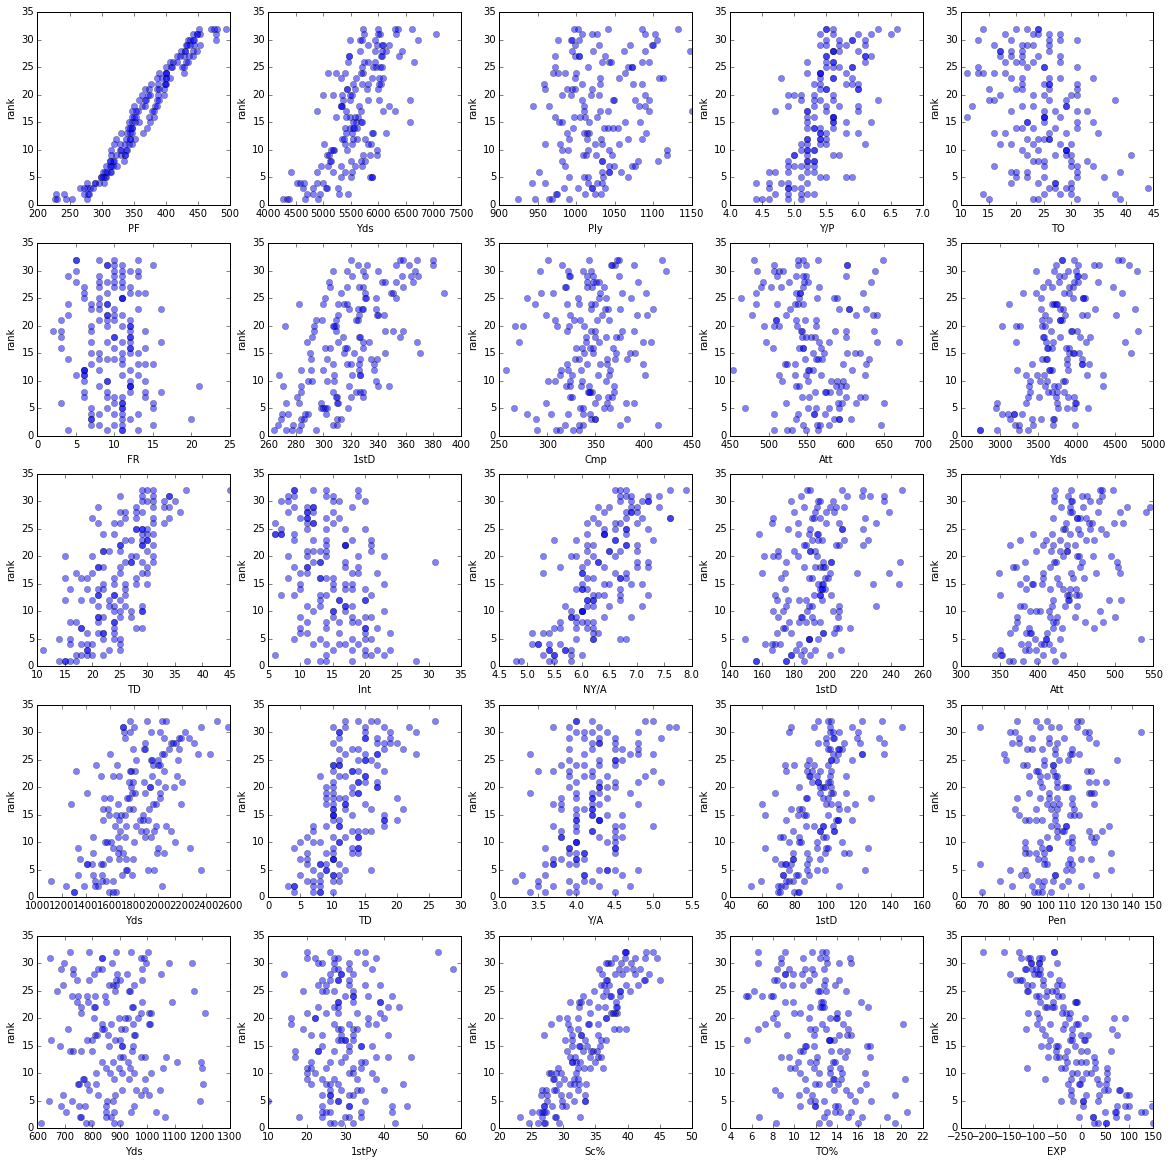

In [4]:
plt.figure(figsize=(20,20))

for c in range(X.shape[1]):
    plt.subplot(5,5, c+1)
    plt.plot(X[:,c], T, 'o', alpha=0.5)
    plt.ylabel(Tname)
    plt.xlabel(Xnames[c])

Below is a quick comparison of the linear and neural net models. We wanted to get an idea of how well the model predicted rank by visualizing RMSE at various parameters. We utilized the trainValidateTestKFolds function given in class to determine which neural net parameters generate the lowest test RMSE. We saw the neural net model typically had an RMSE near 2 with the best parameters. This would mean that on average, the model is off by 2 ranks.


In [5]:
parms = list(itertools.product([2,5,10, 20, [5,5], [10,2,10]], [10,20,100]))
result = trainValidateTestKFolds(trainNN,evaluateNN,X,T,
                                 parms,nFolds=5,shuffle=False)

print('NN Model\n(hidden units, iterations), train, validate, test RMSE')
for x in result:
    print('{:}  \t\t    {:.3f}   {:.3f}   {:.3f}'.format(*x))

    
result = trainValidateTestKFolds(trainLinear,evaluateLinear,X,T,
                                 range(0,11),nFolds=5,shuffle=False)

print("\n",'Linear Model\nlambda, train, validate, test RMSE')
for x in result:
    print('{:.2f}    {:.3f}   {:.3f}   {:.3f}'.format(*x))

NN Model
(hidden units, iterations), train, validate, test RMSE
(5, 20)  		    1.357   2.112   2.806
(5, 20)  		    1.541   2.586   1.411
(10, 20)  		    1.242   1.986   2.737
(20, 20)  		    1.592   2.395   1.725
(10, 20)  		    1.350   2.287   2.284

 Linear Model
lambda, train, validate, test RMSE
1.00    1.716   2.277   3.290
1.00    2.064   2.798   1.757
0.00    1.626   2.046   3.465
1.00    2.033   2.566   2.100
1.00    2.092   2.757   1.627


<br><br>After running the above code a few times, we found that a neural network with 10 hidden units and 20 iterations generally gave the best results. This model typically produced low test RMSE, so we chose these parameters to visualize what ranks were being predicted. Below is a list of each team, the rank the model predicted, and the actual rank. We decided to report the number of correct predictions within one rank, since the results would otherwise be largely skewed toward worse results if a single team was far out of place, displacing many other teams by one.

In [58]:
NeuralNetAverages = []

nnet = nn.NeuralNetwork(X.shape[1],[10],T.shape[1])

model = nnet.train(X[0:X.shape[0]*.8,:],T[0:X.shape[0]*.8,:],20)

for i in range(128,160):   
    use = model.use(X[i:i+1,:])[0]
    NeuralNetAverages.append((use, TeamNames[i]))

printRanks(NeuralNetAverages,TeamNames)

NeuralNetAverages = []

Seattle Seahawks15 	Predicted Rank: 1 	Actual Rank: 1
Kansas City Chiefs15 	Predicted Rank: 2 	Actual Rank: 3
Cincinnati Bengals15 	Predicted Rank: 3 	Actual Rank: 2
New York Jets15 	Predicted Rank: 4 	Actual Rank: 9
Carolina Panthers15 	Predicted Rank: 5 	Actual Rank: 6
New England Patriots15 	Predicted Rank: 6 	Actual Rank: 10
Arizona Cardinals15 	Predicted Rank: 7 	Actual Rank: 8
Denver Broncos15 	Predicted Rank: 8 	Actual Rank: 4
Minnesota Vikings15 	Predicted Rank: 9 	Actual Rank: 5
Green Bay Packers15 	Predicted Rank: 10 	Actual Rank: 12
Houston Texans15 	Predicted Rank: 11 	Actual Rank: 7
Pittsburgh Steelers15 	Predicted Rank: 12 	Actual Rank: 11
St. Louis Rams15 	Predicted Rank: 13 	Actual Rank: 13
Atlanta Falcons15 	Predicted Rank: 14 	Actual Rank: 14
Buffalo Bills15 	Predicted Rank: 15 	Actual Rank: 15
Dallas Cowboys15 	Predicted Rank: 16 	Actual Rank: 16
Washington Redskins15 	Predicted Rank: 17 	Actual Rank: 17
Oakland Raiders15 	Predicted Rank: 18 	Actual Rank: 22
San Fran

<br>
After running the neural net with the above parameters, we decided to run the nets with many different combinations of parameters and average the results to see if it did any better. We found that calculating the average in this way did fairly well, though there were times when the neural net would give a predicted rank far off from the actual rank. In order to make up for this, we decided to standardize the data and remove any ranks beyond 3 standard deviations from the mean.

In [59]:
def computeAveragesOfNeuralNets(X,T):
    
    parms = list(itertools.product([2,5,10, 20, [10,2,10]], [0,10,20,50,100]))

    TeamAveragesOverIters = np.ones((32,25))

#     Create a 2D array and cycle through each parameter creating a neural net with each set of parameters. Add the 
#     raw predicted rank at each parameter, for each team  into the 2D array.
    parmCount = 0
    for parm in parms:
        nnet = nn.NeuralNetwork(X.shape[1],parm[0],T.shape[1])
        model = nnet.train(X[0:X.shape[0]*.8,:],T[0:X.shape[0]*.8,:],parm[1])
        for i in range(128,160): 
            use = model.use(X[i:i+1,:])[0]
            TeamAveragesOverIters[i-128][parmCount] = use
        parmCount = parmCount + 1

    NeuralNetAverages = []
    
#     Compute the average rank computed in the previous step for each team and each set of parameters. Remove any
#     rank that is an outlier when computing averages. Add the average rank and the team name to a list of predicted
#     team ranks.
    for i in range(0,32):
        withinStds = (abs(TeamAveragesOverIters[i] - np.mean(TeamAveragesOverIters[i])) < 3 * np.std(TeamAveragesOverIters[i])) 
        withinStdCount = 0
        teamSum = 0
        for j in range(25):
            if withinStds[j]:
                withinStdCount = withinStdCount + 1 
                teamSum += TeamAveragesOverIters[i][j]

        NeuralNetAverages.append((float(teamSum/withinStdCount),TeamNames[i+128]))
    
    return NeuralNetAverages

In [60]:
X,T,Xnames,Tname,TeamNames = makeFootballData()
        
NeuralNetAverages = []

NeuralNetAverages = computeAveragesOfNeuralNets(X,T)

printRanks(NeuralNetAverages,TeamNames)


Seattle Seahawks15 	Predicted Rank: 1 	Actual Rank: 1
Kansas City Chiefs15 	Predicted Rank: 2 	Actual Rank: 3
Cincinnati Bengals15 	Predicted Rank: 3 	Actual Rank: 2
Minnesota Vikings15 	Predicted Rank: 4 	Actual Rank: 5
New England Patriots15 	Predicted Rank: 5 	Actual Rank: 10
Denver Broncos15 	Predicted Rank: 6 	Actual Rank: 4
Green Bay Packers15 	Predicted Rank: 7 	Actual Rank: 12
Arizona Cardinals15 	Predicted Rank: 8 	Actual Rank: 8
Houston Texans15 	Predicted Rank: 9 	Actual Rank: 7
Carolina Panthers15 	Predicted Rank: 10 	Actual Rank: 6
New York Jets15 	Predicted Rank: 11 	Actual Rank: 9
Pittsburgh Steelers15 	Predicted Rank: 12 	Actual Rank: 11
St. Louis Rams15 	Predicted Rank: 13 	Actual Rank: 13
Atlanta Falcons15 	Predicted Rank: 14 	Actual Rank: 14
Buffalo Bills15 	Predicted Rank: 15 	Actual Rank: 15
Dallas Cowboys15 	Predicted Rank: 16 	Actual Rank: 16
Washington Redskins15 	Predicted Rank: 17 	Actual Rank: 17
San Francisco 49ers15 	Predicted Rank: 18 	Actual Rank: 18
Miam

##Results

For both the regular and averaged neural net models we used 2011-2014 seasons to train the neural nets, and tested on the 2015 data. We wanted to do this instead of a random combination of the total data to best test the predictiveness of the model (using past years to predict future years).

<br>
For our results, team ranks were predicted by taking the sorted order of teams and their predicted ranks. Meaning the order of the teams in the neural net was the final rank. In the second prediction, we trained the neural net model multiple times with the different parameters, and averaged the results across these models. Below shows the raw averages. As mentioned before, we ranked the results by ordering these averages. So even though the Seahawks were given a predicted rank around 5, the final rank given is 1, because it is the lowest predicted rank of the set.

In [9]:
for i in sorted(NeuralNetAverages):
    print(i)

(5.88992501833589, 'Seattle Seahawks15')
(5.970359411182314, 'Kansas City Chiefs15')
(6.418428286439982, 'Cincinnati Bengals15')
(8.031772199406275, 'Denver Broncos15')
(8.052221491477535, 'Minnesota Vikings15')
(8.604091408863002, 'Green Bay Packers15')
(8.754605970722372, 'New England Patriots15')
(8.976697936414686, 'Carolina Panthers15')
(9.054298483895897, 'New York Jets15')
(9.061980714462026, 'Houston Texans15')
(9.168574116483574, 'Arizona Cardinals15')
(10.126994900276582, 'Pittsburgh Steelers15')
(10.869621196499379, 'St. Louis Rams15')
(14.323297221352911, 'Atlanta Falcons15')
(17.565216076498036, 'Buffalo Bills15')
(19.28118204122732, 'Dallas Cowboys15')
(20.581004197079828, 'Washington Redskins15')
(20.72286934722364, 'San Francisco 49ers15')
(21.605575765756722, 'Oakland Raiders15')
(21.983789426410166, 'Miami Dolphins15')
(22.73011182678285, 'Chicago Bears15')
(23.037867325471986, 'Detroit Lions15')
(23.268470144890237, 'Baltimore Ravens15')
(23.32276429096989, 'San Dieg

We ran the above code 25 times to get averages for each approach. The regular neural net averaged 64.38% correct within one rank while the averaged neural net got an average of 75.94% correct. After removing outliers we got an average of 78.13% correct. Our model on average did 13% better, which is a fairly significant increase. 
<br> <br>
This model would work best for ranked predictions. Considering we are significantly more accurate than a normal neural net, we can assume that averaging over multiple neural nets can be beneficial. In its current form, the model is unable to help make predictions for specific games. You could use the predicted ranks as a general guide however, when choosing a team based on their defensive capabilities for Fantasy Football. 

###Future Work

We would like to eventually refine our model to give even better predictions, ideally above 90% correct.  One way we could do this is by using data from past seasons beyond 2011. A larger pool of data to train on would most likely improve predictions. Additionally, we would like to apply the same approach to different sets of rank based data, such as offensive stats, or individual player stats. If the model continued to give good results with these data sets, then it could even be expanded to NASCAR or horse racing.


<br>
###Team Contributions
Michael Falcone: <br>
Wrote code for training and evaluating models <br>
Wrote code for averaging multiple neural nets <br>
Wrote code for extracting team ranks out of model <br>
Worked on results and future work sections <br> <br>
Kyle Kurth: <br>
Wrote code to read in data<br>
Graphed data<br>
Wrote code for printing model<br>
Data analysis and writing for overview and data section<br>
Worked on results and future work sections <br> 